In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import date

In [2]:
from random import choice, randint, randrange, seed

In [3]:
from components.metrics import calculate_regression_metrics, print_model_metrics
from components.preprocessing.addtional_data import format_data
from components.preprocessing.utils import emp_convert_string, null_values_df, selected_variables

In [4]:
TARGET = 'charges'

In [5]:
N = 500

In [6]:
pd.read_csv(r"C:\dev\projects\gcp_prep\bmi.csv")

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3
...,...,...,...,...
495,Female,150,153,5
496,Female,184,121,4
497,Female,141,136,5
498,Male,150,95,5


In [7]:
df = pd.read_csv(r"C:\dev\projects\gcp_prep\bmi.csv")

In [8]:
df['age'] = [randint(18, 65) for _ in range(N)]

In [9]:
df['region'] = [choice(["southwest", "northwest", "south", "north", "east", "west"]) for _ in range(N)]

In [10]:
df['smoker'] = [choice(["yes", "no"]) for _ in range(N)]

In [11]:
df['bmi'] = df.Weight/df.Height

In [12]:
df['charges'] = [randint(0, 50000) for _ in range(N)]

In [13]:
df['children'] = df.Index

In [14]:
Y_TRAIN = df[TARGET]

In [15]:
df.columns = df.columns.str.lower()

In [16]:
df

,gender,height,weight,index,age,region,smoker,bmi,charges,children
0,Male,174,96,4,63,north,yes,0.551724,27918,4
1,Male,189,87,2,49,north,no,0.460317,25132,2
2,Female,185,110,4,38,southwest,no,0.594595,16982,4
3,Female,195,104,3,30,northwest,no,0.533333,16234,3
4,Male,149,61,3,53,southwest,no,0.409396,12284,3
...,...,...,...,...,...,...,...,...,...,...
495,Female,150,153,5,39,northwest,yes,1.020000,41335,5
496,Female,184,121,4,63,south,yes,0.657609,18982,4
497,Female,141,136,5,22,north,yes,0.964539,314,5
498,Male,150,95,5,26,north,yes,0.633333,24347,5


In [17]:
feature_df = format_data(df)

In [18]:
feature_df.SEX_CD.value_counts()

1    500
Name: SEX_CD, dtype: int64

In [19]:
feature_df.head()

,gender,height,weight,index,age,region,smoker,bmi,charges,children,...,CUS_ID,EMP_ID,ADDRESS_ID,DOB_DT,VALID_FR_DT,EMP_TYP,EMP_SAL_FRQ,SEX_CD,DEPEND_CNT,TARGET
0,Male,174,96,4,63,north,1,0.551724,27918,4,...,1,409,8078,1920-01-01,1920-01-01,UN,Weekly,1,4,27918
1,Male,189,87,2,49,north,0,0.460317,25132,2,...,2,307,7960,1920-01-01,1920-01-01,PT,Annual,1,2,25132
2,Female,185,110,4,38,southwest,0,0.594595,16982,4,...,3,348,5602,1920-01-01,1920-01-01,STU,Weekly,1,4,16982
3,Female,195,104,3,30,northwest,0,0.533333,16234,3,...,4,23,5802,1920-01-01,1920-01-01,RT,Annual,1,3,16234
4,Male,149,61,3,53,southwest,0,0.409396,12284,3,...,5,118,6049,1920-01-01,1920-01-01,UN,Annual,1,3,12284


In [20]:
feature_df.columns

Index(['gender', 'height', 'weight', 'index', 'age', 'region', 'smoker', 'bmi',
       'charges', 'children', 'region_east', 'region_north',
       'region_northwest', 'region_south', 'region_southwest', 'region_west',
       'REGION', 'AGE', 'CUS_ID', 'EMP_ID', 'ADDRESS_ID', 'DOB_DT',
       'VALID_FR_DT', 'EMP_TYP', 'EMP_SAL_FRQ', 'SEX_CD', 'DEPEND_CNT',
       'TARGET'],
      dtype='object')

In [21]:
feature_df[['children', 'region_east', 'region_north',
       'region_northwest', 'region_south', 'region_southwest', 'region_west',
       'REGION', 'AGE', 'CUS_ID', 'EMP_ID', 'ADDRESS_ID', 'DOB_DT',
       'VALID_FR_DT', 'EMP_TYP', 'EMP_SAL_FRQ', 'SEX_CD', 'DEPEND_CNT', 'TARGET']]

,children,region_east,region_north,region_northwest,region_south,region_southwest,region_west,REGION,AGE,CUS_ID,EMP_ID,ADDRESS_ID,DOB_DT,VALID_FR_DT,EMP_TYP,EMP_SAL_FRQ,SEX_CD,DEPEND_CNT,TARGET
0,4,0,1,0,0,0,0,north,63,1,409,8078,1920-01-01,1920-01-01,UN,Weekly,1,4,27918
1,2,0,1,0,0,0,0,north,49,2,307,7960,1920-01-01,1920-01-01,PT,Annual,1,2,25132
2,4,0,0,0,0,1,0,southwest,38,3,348,5602,1920-01-01,1920-01-01,STU,Weekly,1,4,16982
3,3,0,0,1,0,0,0,northwest,30,4,23,5802,1920-01-01,1920-01-01,RT,Annual,1,3,16234
4,3,0,0,0,0,1,0,southwest,53,5,118,6049,1920-01-01,1920-01-01,UN,Annual,1,3,12284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,0,0,1,0,0,0,northwest,39,496,334,6311,1920-01-01,1920-01-01,PT,Weekly,1,5,41335
496,4,0,0,0,1,0,0,south,63,497,225,8181,1920-01-01,1920-01-01,FT,Monthly,1,4,18982
497,5,0,1,0,0,0,0,north,22,498,263,9697,1920-01-01,1920-01-01,FT,Weekly,1,5,314
498,5,0,1,0,0,0,0,north,26,499,229,5008,1920-01-01,1920-01-01,UN,Weekly,1,5,24347


In [22]:
X_TRAIN = feature_df.drop([TARGET, "TARGET"], axis=1)

In [23]:
power_point_df = null_values_df(feature_df)[['children', 'region_east', 'region_north',
       'region_northwest', 'region_south', 'region_southwest', 'region_west',
       'REGION', 'AGE', 'CUS_ID', 'EMP_ID', 'ADDRESS_ID', 'DOB_DT',
       'VALID_FR_DT', 'EMP_TYP', 'EMP_SAL_FRQ', 'SEX_CD', 'DEPEND_CNT', 'TARGET']]

# Part 1 Pandas Profiling report

## Overview

## Dataset Info

In [24]:
power_point_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          500 non-null    int64  
 1   region_east       500 non-null    uint8  
 2   region_north      500 non-null    uint8  
 3   region_northwest  500 non-null    uint8  
 4   region_south      500 non-null    uint8  
 5   region_southwest  500 non-null    uint8  
 6   region_west       500 non-null    uint8  
 7   REGION            500 non-null    object 
 8   AGE               476 non-null    float64
 9   CUS_ID            500 non-null    int64  
 10  EMP_ID            0 non-null      float64
 11  ADDRESS_ID        500 non-null    int32  
 12  DOB_DT            500 non-null    object 
 13  VALID_FR_DT       500 non-null    object 
 14  EMP_TYP           500 non-null    object 
 15  EMP_SAL_FRQ       408 non-null    object 
 16  SEX_CD            500 non-null    int64  
 1

## Numerical Features

In [25]:
power_point_df.describe()

,children,region_east,region_north,region_northwest,region_south,region_southwest,region_west,AGE,CUS_ID,EMP_ID,ADDRESS_ID,SEX_CD,DEPEND_CNT,TARGET
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,476.00000,500.000000,0.0,500.000000,500.0,500.000000,500.000000
mean,3.748000,0.164000,0.180000,0.14600,0.176000,0.180000,0.15400,42.57563,250.500000,NaN,7539.804000,1.0,3.748000,24866.566000
std,1.355053,0.370646,0.384572,0.35346,0.381202,0.384572,0.36131,13.81062,144.481833,NaN,1430.231611,0.0,1.355053,13940.597307
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,18.00000,1.000000,NaN,5006.000000,1.0,0.000000,177.000000
25%,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,31.00000,125.750000,NaN,6301.750000,1.0,3.000000,12520.500000
50%,4.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,44.00000,250.500000,NaN,7607.500000,1.0,4.000000,25492.000000
75%,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,54.00000,375.250000,NaN,8740.250000,1.0,5.000000,36654.000000
max,5.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,65.00000,500.000000,NaN,9996.000000,1.0,5.000000,49767.000000


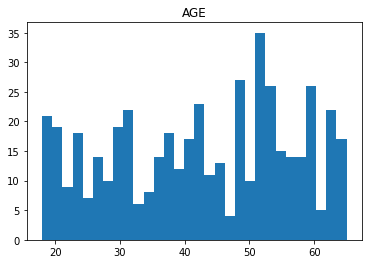

count    476.00000
mean      42.57563
std       13.81062
min       18.00000
25%       31.00000
50%       44.00000
75%       54.00000
max       65.00000
Name: AGE, dtype: float64


In [26]:
selected_variables(power_point_df, "AGE")

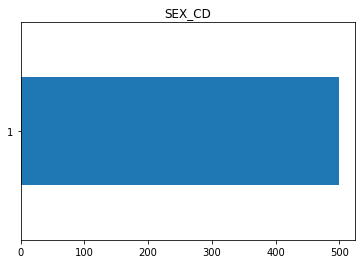

1    500
Name: SEX_CD, dtype: int64


In [27]:
power_point_df.SEX_CD.value_counts().plot.barh()
plt.title("SEX_CD")
plt.show()
print(power_point_df.SEX_CD.value_counts())

In [28]:
# selected_variables(power_point_df, "EMP_YEAR")

In [29]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            500 non-null    object 
 1   height            500 non-null    int64  
 2   weight            500 non-null    int64  
 3   index             500 non-null    int64  
 4   age               500 non-null    int64  
 5   region            500 non-null    object 
 6   smoker            500 non-null    int64  
 7   bmi               500 non-null    float64
 8   charges           500 non-null    int64  
 9   children          500 non-null    int64  
 10  region_east       500 non-null    uint8  
 11  region_north      500 non-null    uint8  
 12  region_northwest  500 non-null    uint8  
 13  region_south      500 non-null    uint8  
 14  region_southwest  500 non-null    uint8  
 15  region_west       500 non-null    uint8  
 16  REGION            500 non-null    object 
 1

In [30]:
corr_features = ['AGE', 'EMP_TYP', 'EMP_SAL_FRQ', 'SEX_CD', 'DEPEND_CNT', 'TARGET']

In [31]:
print("Feature and traget correlation with spearman coef \n")
corr_df = feature_df[corr_features].corr(method="spearman")
corr_df.where(np.tril(np.ones(corr_df.shape)).astype(bool)).replace(np.nan, "", regex=True)

Feature and traget correlation with spearman coef 



,AGE,SEX_CD,DEPEND_CNT,TARGET
AGE,1.0,,,
SEX_CD,,,,
DEPEND_CNT,0.047358,,1.0,
TARGET,0.035594,,-0.030868,1.0


In [32]:
from sklearn.linear_model import LinearRegression

LinearRegression(fit_intercept=False, normalize=True, copy_X=False, n_jobs=1)

LinearRegression(copy_X=False, fit_intercept=False, n_jobs=1, normalize=True)

In [33]:
from sklearn.ensemble import RandomForestRegressor

RandomForestRegressor(n_estimators=100, criterion="squared_error", max_depth=5,
                      min_samples_leaf=1, max_features="auto", max_leaf_nodes=None,
                      bootstrap=True, n_jobs=1, random_state=22
                     )

RandomForestRegressor(max_depth=5, max_features='auto', n_jobs=1,
                      random_state=22)

In [34]:
feature_p_values_df = pd.DataFrame(data=[1]*df.shape[0], columns=["constant"])

In [35]:
feature_p_values_df = pd.concat([feature_p_values_df, emp_convert_string(X_TRAIN)[[
    'children', 'region_east', 'region_north',
       'region_northwest', 'region_south', 'region_southwest', 'region_west',
       'AGE', 'CUS_ID', 'EMP_ID', 'ADDRESS_ID',  'SEX_CD', 'DEPEND_CNT'
]]], axis=1)

In [36]:
feature_p_values_df

,constant,children,region_east,region_north,region_northwest,region_south,region_southwest,region_west,AGE,CUS_ID,EMP_ID,ADDRESS_ID,SEX_CD,DEPEND_CNT
0,1,4,0,1,0,0,0,0,63,1,409,8078,1,4
1,1,2,0,1,0,0,0,0,49,2,307,7960,1,2
2,1,4,0,0,0,0,1,0,38,3,348,5602,1,4
3,1,3,0,0,1,0,0,0,30,4,23,5802,1,3
4,1,3,0,0,0,0,1,0,53,5,118,6049,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,5,0,0,1,0,0,0,39,496,334,6311,1,5
496,1,4,0,0,0,1,0,0,63,497,225,8181,1,4
497,1,5,0,1,0,0,0,0,22,498,263,9697,1,5
498,1,5,0,1,0,0,0,0,26,499,229,5008,1,5


In [37]:
mod = sm.OLS(Y_TRAIN, feature_p_values_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4809
Date:                Wed, 14 Dec 2022   Prob (F-statistic):              0.903
Time:                        17:35:47   Log-Likelihood:                -5477.8
No. Observations:                 500   AIC:                         1.098e+04
Df Residuals:                     489   BIC:                         1.102e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
constant          1.215e+04   1998.052  

## Features

In [38]:
x_train, x_test, y_train, y_test = train_test_split(feature_p_values_df, Y_TRAIN, random_state=42)

In [39]:
lin_reg1 = linear_model.LinearRegression()
lin_reg1.fit(x_train, y_train)
y_pred1 = lin_reg1.predict(x_train)
lin_reg2 = linear_model.LinearRegression()
lin_reg2.fit(x_test, y_test)
y_pred2 = lin_reg2.predict(x_test)


In [40]:
train_set_1 = print_model_metrics(x_train, y_train, y_pred1)

Coefficient of determination (R squared): 	 0.03
Correlation with pearson coefficient 	 nan 
Correlation with spearman coefficient 	 nan 
Mape absolute percentage error: 	 187.31 
Mean squared error: 	 191870162.45 
